![header](./images/beertaps.png)

# Beer-Recommendation System: Content Based Recommendations
Author: Ashli Dougherty 

# Overview

This project's goal is to build a recommendation system for the beer enthusiast. I am interested in creating both a content based and collaborative filtering recommendation system. 
- A content based system will make recommendations based on a beer's features. The content based system will allow any user to enter a beer/characteristic and in return they will be given the names of other beers they will (hopefully) enjoy drinking.  
- The collaborative system will recommend items based on the ratings of other users. This system will compare beer drinker/reviewer profiles and then recommend items based on the similarity between these users. 


# Business Understanding

As of December 2021, there are more than [9,000 breweries](https://vinepair.com/booze-news/us-record-number-breweries-2021/#:~:text=Even%20after%20the%20setbacks%20of,beer%20producers%20in%20the%20U.S.)in the US alone. Even though some taprooms were forced to shut their doors during the pandemic, the craft beer business is still going strong. The [Brewer’s Association](https://www.brewersassociation.org/statistics-and-data/national-beer-stats/) is expecting an increase in craft brewery volume share in the post-pandemic industry market, and reported that craft beer retail sales were over $26 billion dollars in 2021.    
  
Currently, there are mobile apps (like [Untapped](https://untappd.com/)) and websites (like [Beer Advocate](https://www.beeradvocate.com/)) that allow you to personally track and rate the beer you try, but consumers should know they can enjoy their next sip (or pint) with confidence. There are so many options on the market that choosing which beverage to buy next, what brewery to visit in person, or which booth to stand in line for at a festival can seem overwhelming. My goal is to provide a system for beer enthusiasts to try new beers that they are guaranteed to love. Cheers!

# Collaborative Filtering

display undertanding and overall approach

# Imports & Functions

Standard imports, **EXPLAIN SURPRISE**
[Documentation here.](https://surprise.readthedocs.io/en/stable/index.html)
[Github here.](https://github.com/NicolasHug/Surprise)

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import BaselineOnly, NormalPredictor
from surprise.prediction_algorithms import SVD, SVDpp, NMF

# Load Data
Loading 'Reviews' CSV created from the [DataPrep Notebook](./DataPrep.ipynb). As stated in other notebook, because this a user to user recommendation system only reviews with 5 or more reviews were kept. 

In [179]:
df = pd.read_csv('../BeerData/reviews_cleaned.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,brewery_id,brewery_name,review_overall,beer_style,beer_name,beer_abv,beer_id,user_id
0,10325,Vecchio Birraio,1.5,Wheat Beer,Sausa Weizen,Low,47986,13329
1,10325,Vecchio Birraio,3.0,Strong Ale,Red Moon,Medium,48213,13329
2,10325,Vecchio Birraio,3.0,Stout,Black Horse Black Beer,Medium,48215,13329
3,10325,Vecchio Birraio,3.0,Pale Lager,Sausa Pils,Low,47969,13329
4,1075,Caldera Brewing Company,4.0,India Pale Ale,Cauldron DIPA,Medium,64883,10108


In [180]:
#checking shape
df.shape

(1470272, 8)

In [181]:
#checking info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470272 entries, 0 to 1470271
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   brewery_id      1470272 non-null  int64  
 1   brewery_name    1470272 non-null  object 
 2   review_overall  1470272 non-null  float64
 3   beer_style      1470272 non-null  object 
 4   beer_name       1470272 non-null  object 
 5   beer_abv        1470272 non-null  object 
 6   beer_id         1470272 non-null  int64  
 7   user_id         1470272 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 89.7+ MB


# Train Test Split
need to use tts from surprise, have to read in df and use specific columns in specific order, set the ratings on a sclae from 1-5

In [153]:
# instantiate a 'Reader' to read in the data so Surprise can use it
# rating_scale will be bounded by 1 and 5
reader = Reader(rating_scale=(1,5))

In [154]:
#loading relevant columns from dataframe
data = Dataset.load_from_df(df[['user_id', 'beer_id', 'review_overall']], reader)

In [155]:
# use surprise train test split 
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [156]:
# examining number of users and items in train set
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items)

Number of users:  14549 

Number of items:  45452


# Baseline Models


### Baseline Only

In [157]:
#intantiate model 
baseline = BaselineOnly()

#fit and get predictions 
predictions = baseline.fit(trainset).test(testset)

#score baseline model
baseline_score = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.5961


### Normal Predictor

In [158]:
#intantiate model 
normal = NormalPredictor()

#fit and get predictions 
predictions2 = normal.fit(trainset).test(testset)

#score baseline model
normal_score = accuracy.rmse(predictions2)

RMSE: 0.9826


> **Baseline evaluation**: BaselineOnly model was able to predict the score of the beer within approximately 0.6 points. This was ~0.4 better than the NormalPredictor model.

# Determining the Best Model
**explain why i used these** Will be looking at the maxtrix factorizaton based models within surprise's library. I decided to use these algorithms as it was the type that was used for the famous "Netflix Challenge" that increased the accuracy of the company's recommendation sytstem by 10%. 

SVD based models include SVD, SVD++, and NMF. Each model will be run with default parameters and cross validated. After this a grid search will be ran to determine best hyperparamters and RMSE will be compared. 
Documentation for Surprise SVD algorithms can be found [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD). 

Documentation was used to determine which parameters to use during grid searches. Gridsearches are set up the same as when using sklearn. A dictionary of parameters to tune are created and passed to GridSearchCV where best parameters and scores can be determined and evaluated.

## SVD & Gridsearching

In [159]:
#instantiate & cross validate
svd = SVD(random_state=42)
cv_results = cross_validate(svd, data, measures=['rmse'], cv=3, n_jobs=-1, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6006  0.5998  0.6009  0.6004  0.0004  
Fit time          5.10    5.07    5.03    5.07    0.03    
Test time         2.49    2.61    2.42    2.51    0.08    


In [160]:
# fit to train set and get predictions with test set
predictions_svd = svd.fit(trainset).test(testset)

# score svd model
svd_results = accuracy.rmse(predictions_svd)

RMSE: 0.5966


> RMSE for untuned SVD is slightly worse than baseline model. 

In [45]:
# creating svd gridsearch parameters
svd_params = {
    'n_factors': [25, 50, 100],
    'n_epochs': [10, 20, 40],
    'lr_all': [.005, .05],
    'reg_all':  [.02, .05], 
    'biased': [True, False]
}

Parameters being tested in grid search and their defaults: 
> n_factors: the number of factors, default is 100
>
> n_epochs: the number of iterations, default is 20
>
> lr_all: the learning rate for all parameters, default is 0.005
>
> reg_all: the regularization rate for all parameters, default is 0.02
>
> biased: whether to baselines(bias), default is True

In [46]:
# instantiate and fit grid search on data
svd_gs = GridSearchCV(SVD, param_grid=svd_params, 
                      cv=3, joblib_verbose=10, n_jobs=-1)
svd_gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 22

In [48]:
svd_gs.best_params['rmse']

{'n_factors': 100,
 'n_epochs': 40,
 'lr_all': 0.005,
 'reg_all': 0.05,
 'biased': True}

In [53]:
svd_gs.best_score['rmse']

0.5928585014360079

### SVD Model with Best Parameters

In [161]:
# instantiating model using best parameters
svd_gs_model = SVD(n_factors=100, n_epochs=40, lr_all=0.005, 
                   reg_all=0.05, biased=True, random_state=42)

# fitting on train set and getting predictions from test 
svd_gs_predictions = svd_gs_model.fit(trainset).test(testset)

# scoring tuned model
svd_gs_model_score = accuracy.rmse(svd_gs_predictions)


RMSE: 0.5906


> Surprisingly the tuned SVD model scored just slightly better than the baseline model (RMSE: 0.5962). In order to see if there is a model with a lower RMSE I will continue onto the SVD++ model.

## SVD++ & Gridsearching

In [162]:
#instantiate & cross validate
svdpp = SVDpp(random_state=42)
cv_results = cross_validate(svdpp, data, measures=['rmse'], cv=3, n_jobs=-1, verbose=True)

Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5945  0.5939  0.5944  0.5943  0.0003  
Fit time          282.28  282.57  282.19  282.35  0.16    
Test time         100.61  97.24   97.78   98.55   1.48    


In [163]:
# fit to train set and get predictions with test set
predictions_svdpp = svd.fit(trainset).test(testset)

# score svd++ model
svdpp_results = accuracy.rmse(predictions_svdpp)

RMSE: 0.5966


> RMSE for untuned SVD++ model is 0.5966 which is the exact same score as the untuned SVD model.

In [61]:
# creating svd gridsearch parameters
svdpp_params = {
    'n_factors': [20, 50, 100],
    'n_epochs': [10, 20, 40],
    'lr_all': [0.025, .005, .007],
    'reg_all': [.01, .02, .05]
}

Parameters being tested in grid search and their defaults: 
> n_factors: the number of factors, default is 20
>
> n_epochs: the number of iterations, default is 20
>
> lr_all: the learning rate for all parameters, default is 0.007
>
> reg_all: the regularization rate for all parameters, default is 0.02
>

In [62]:
# instantiate and fit grid search on data
svdpp_gs = GridSearchCV(SVDpp, param_grid=svdpp_params, 
                      cv=3, joblib_verbose=10, n_jobs=-1)
svdpp_gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 51.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 72.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 96.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 138.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 218.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 339.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 452.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 583.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 742.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 981.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elap

> The grid search above takes a VERY long time to run. Due to this it is commented out and the best parameters and score are recorded below.  
> The best parameters are {'n_factors': 20, 'n_epochs': 40, 'lr_all': 0.007, 'reg_all': 0.05}

In [63]:
svdpp_gs.best_params['rmse']

{'n_factors': 20, 'n_epochs': 40, 'lr_all': 0.007, 'reg_all': 0.05}

In [64]:
svdpp_gs.best_score['rmse']

0.5909992916367263

### SVD++ Model with Best Parameters

In [164]:
# instantiating model using best parameters
svdpp_gs_model = SVDpp(n_factors=20, n_epochs=40, lr_all=0.007, 
                   reg_all=0.05, random_state=42)

# fitting on train set and getting predictions from test 
svdpp_gs_predictions = svdpp_gs_model.fit(trainset).test(testset)

# scoring tuned model
svdpp_gs_model_score = accuracy.rmse(svdpp_gs_predictions)

RMSE: 0.5893


> RMSE of 0.58 is so far the best score.

## NMF & Gridsearching

A collaborative filtering algorithm based on Non-negative Matrix Factorization.

In [165]:
#instantiate & cross validate
nmf = NMF(random_state=42)
cv_results = cross_validate(nmf, data, measures=['rmse'], cv=3, n_jobs=-1, verbose=True)

Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6198  0.6199  0.6195  0.6197  0.0002  
Fit time          8.15    8.13    8.10    8.13    0.02    
Test time         2.10    2.18    2.02    2.10    0.06    


In [166]:
# fit to train set and get predictions with test set
predictions_nmf = nmf.fit(trainset).test(testset)

# score nmf model
nmf_results = accuracy.rmse(predictions_nmf)

RMSE: 0.6139


> So far this is the worst score. I will grid search to see if there is a better fit. 

In [69]:
# creating nmf gridsearch parameters
nmf_params = {
    'n_factors': [15, 30, 50],
    'n_epochs': [25, 50, 100],
    'biased': [True, False]
}

Parameters being tested in grid search and their defaults: 
> n_factors: the number of factors, default is 15
>
> n_epochs: the number of iterations, default is 50
>
> biased: whether to use bseline, default is False.
>

In [70]:
# instantiate and fit grid search on data
nmf_gs = GridSearchCV(NMF, param_grid=nmf_params, 
                      cv=3, joblib_verbose=10, n_jobs=-1)
nmf_gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  45 out of  54 | elapsed:  8.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  51 out of  54 | elapsed:  9.1min remaining:   32.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  9.2min finished


In [71]:
nmf_gs.best_params['rmse']

{'n_factors': 15, 'n_epochs': 50, 'biased': True}

In [77]:
nmf_gs.best_score['rmse']

0.5959051294761678

### NMF Model with best Parameters

In [167]:
# instantiating model using best parameters
nmf_gs_model = NMF(n_factors=15, n_epochs=50, biased=True, random_state=42)

# fitting on train set and getting predictions from test 
nmf_gs_predictions = nmf_gs_model.fit(trainset).test(testset)

# scoring tuned model
nmf_gs_model_score = accuracy.rmse(nmf_gs_predictions)

RMSE: 0.5946


> The RMSE decreased from the untuned to tuned model, but this model still did not perform as well as the tuned SVD++ model.

# Evaluation of Models

The model with the highest error was the NormalPredict model with an RMSE of 0.9840. The Baseline model itself had an RMSE of 0.5962 and several tuned and untuned models actuall scored worse than the Baseline. These two were the numbers I used to compare to the other tuned and untuned models. Unfortunately the RMSE did not change much from the baseline model with the tuned **SVD++ model having the lowest RMSE of 0.5893**.

Most beers are rated around a 4.0, so being off any rating by approximately 0.6 I think I can still confidently recommend beers to users that they will enjoy using almost any of these models. I will be using the SVD++ as it has the lowest error. 

In [168]:
#creating variables for visual comparison
x = ['NMF', 'SVD', 'SVD++','Baseline', 'NFM_GS', 'SVD_GS','SVD++_GS']
y = [nmf_results, svd_results, svdpp_results, baseline_score,
     nmf_gs_model_score, svd_gs_model_score, svd_gs_model_score]

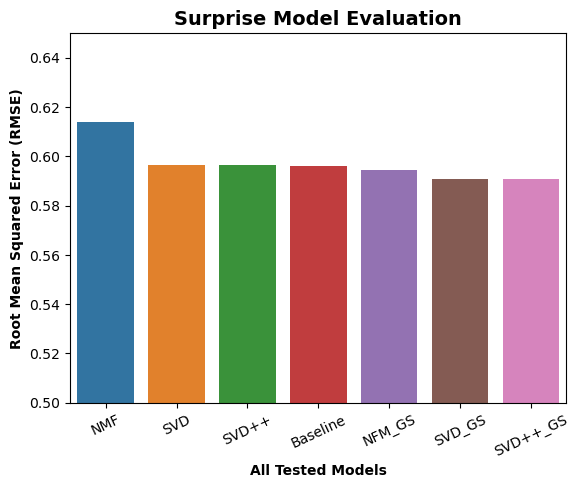

In [169]:
sns.barplot(x, y)
plt.xticks(rotation=25)
plt.ylim(0.5, 0.65)
plt.ylabel('Root Mean Squared Error (RMSE)', weight='bold')
plt.xlabel('All Tested Models', weight='bold')
plt.title('Surprise Model Evaluation', weight='bold', size=14);

## Distribution of Actual & Predicted Scores for Best Model

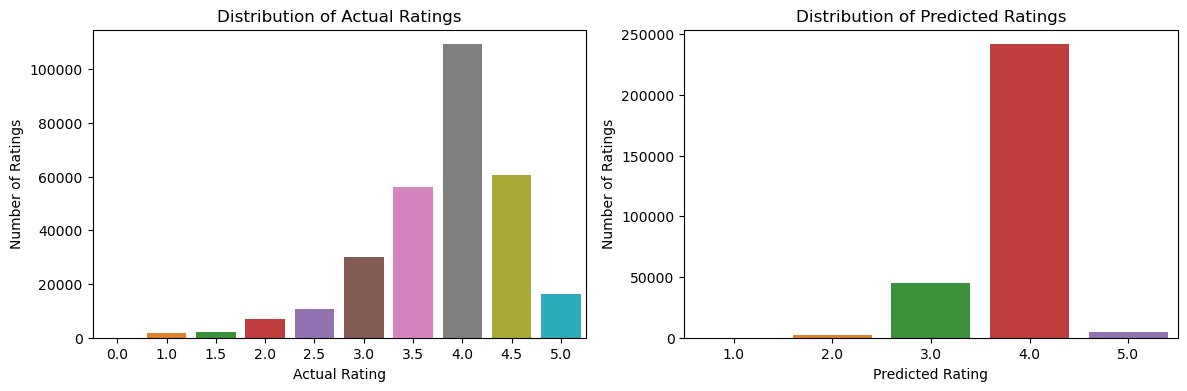

In [170]:
#create df for data extraction 
svdpp_pred_df = pd.DataFrame(svdpp_gs_predictions, columns=['user_id', 'item_id', 'actual_rating', 'predicted_rating', 'details'])
svdpp_pred_df['predicted_rating'] = svdpp_pred_df['predicted_rating'].round()

#create plot comparing distribution
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.countplot(x='actual_rating', data=svdpp_pred_df, ax=ax1)
ax1.set_title('Distribution of Actual Ratings')
ax1.set_xlabel('Actual Rating')
ax1.set_ylabel('Number of Ratings')
sns.countplot(x='predicted_rating', data=svdpp_pred_df, ax=ax2)
ax2.set_title('Distribution of Predicted Ratings')
ax2.set_xlabel('Predicted Rating')
ax2.set_ylabel('Number of Ratings')
plt.show();

> Predicted ratings are actually more spread out/nuanced but for visualization purposes had to be rounded. What stands out to me is that the predictions are likely not rate a beer 5 stars even though thre are thousands of 4.5 and 5.0 rated beers. 

# Building Recommender 

Final model can be used to build a recommender that can return top n-recommendations based on a specific User ID. First, I will need to create a dataframe that contains meta data used for recommendation display. Then build a full training set that incorporates all data so that recommendations can be made using all data. 

In [ ]:
# building full training set so recommendations can be made off full dataset
trainset_full = data.build_full_trainset()
svdpp_gs_model.fit(trainset_full)

In [183]:
df.head(1)

,brewery_id,brewery_name,review_overall,beer_style,beer_name,beer_abv,beer_id,user_id
0,10325,Vecchio Birraio,1.5,Wheat Beer,Sausa Weizen,Low,47986,13329


In [198]:
display_df = pd.DataFrame(df, columns=['beer_id','beer_name', 'brewery_name',
                                       'beer_style', 'beer_abv'])
display_df.set_index('beer_id', inplace=True)
display_df.head(1)

,beer_name,brewery_name,beer_style,beer_abv
beer_id,,,,
47986,Sausa Weizen,Vecchio Birraio,Wheat Beer,Low


In [200]:
#cleaning column names for final display
display_df.rename(columns={'beer_name': 'Beer',
                           'brewery_name': 'Brewery',
                          'beer_style': 'Style',
                          'beer_abv': 'ABV'}, inplace=True)
display_df.head()

,Beer,Brewery,Style,ABV
beer_id,,,,
47986,Sausa Weizen,Vecchio Birraio,Wheat Beer,Low
48213,Red Moon,Vecchio Birraio,Strong Ale,Medium
48215,Black Horse Black Beer,Vecchio Birraio,Stout,Medium
47969,Sausa Pils,Vecchio Birraio,Pale Lager,Low
64883,Cauldron DIPA,Caldera Brewing Company,India Pale Ale,Medium


In [206]:
#creating rating data 
user_df = pd.DataFrame(df, columns=['user_id','beer_id'])
user_df.rename(columns={'user_id': 'UserID'}, inplace=True)
user_df.set_index('UserID', inplace=True)
user_df.head()

,beer_id
UserID,
13329,47986
13329,48213
13329,48215
13329,47969
10108,64883


In [210]:
# user will need to input their id and how many recs they want
# user = input('UserID: ')
# n_recs = int(input('How many recommendations? '))

UserID: 10108
How many recommendations? 5


In [213]:
# list of beers that reviews have already reviewed
already_drank = list(user_df.loc[user, 'beer_id'])

KeyError: '10108'